In [5]:
import sys
sys.path.insert(0, '../')

In [2]:
sys.executable

'c:\\Users\\denis\\anaconda3\\envs\\ucm\\python.exe'

# Libraries

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from urllib.request import urlopen
from bs4 import BeautifulSoup

In [6]:
from src.scrapper import scrape_nba_finals, scrape_NBA_team_data

# Get data

**Example NBA finals**

In [4]:
scrape_nba_finals()

,Year,Lg,Champion,Runner-Up,Finals MVP,,Points,Rebounds,Assists,Win Shares
0,2023,NBA,Denver Nuggets,Miami Heat,N. Jokić,,N. Jokić (600),N. Jokić (269),N. Jokić (190),N. Jokić (5.0)
1,2022,NBA,Golden State Warriors,Boston Celtics,S. Curry,,J. Tatum (615),A. Horford (214),J. Tatum (148),J. Butler (3.8)
2,2021,NBA,Milwaukee Bucks,Phoenix Suns,G. Antetokounmpo,,G. Antetokounmpo (634),G. Antetokounmpo (269),J. Holiday (199),G. Antetokounmpo (3.7)
3,2020,NBA,Los Angeles Lakers,Miami Heat,L. James,,A. Davis (582),L. James (226),L. James (184),A. Davis (4.5)
4,2019,NBA,Toronto Raptors,Golden State Warriors,K. Leonard,,K. Leonard (732),D. Green (223),D. Green (187),K. Leonard (4.9)
5,2018,NBA,Golden State Warriors,Cleveland Cavaliers,K. Durant,,L. James (748),D. Green (222),L. James (198),L. James (5.2)
6,2017,NBA,Golden State Warriors,Cleveland Cavaliers,K. Durant,,L. James (591),K. Love (191),L. James (141),L. James (4.3)
7,2016,NBA,Cleveland Cavaliers,Golden State Warriors,L. James,,K. Thompson (582),D. Green (228),R. Westbrook (198),L. James (4.7)
8,2015,NBA,Golden State Warriors,Cleveland Cavaliers,A. Iguodala,,L. James (601),D. Howard (238),L. James (169),S. Curry (3.9)
9,2014,NBA,San Antonio Spurs,Miami Heat,K. Leonard,,K. Durant (563),T. Duncan (211),R. Westbrook (153),L. James (4.3)


**Example team season**

In [2]:
year = 2022

# URL to scrape, notice f string:
url = f"https://www.basketball-reference.com/leagues/NBA_{year}_standings.html"

# collect HTML data
html = urlopen(url)

# create beautiful soup object from HTML
soup = BeautifulSoup(html, features="html.parser")

# use getText()to extract the headers into a list
titles = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]

# first, find only column headers
headers = titles[1:titles.index("SRS")+1]

# then, exclude first set of column headers (duplicated)
titles = titles[titles.index("SRS")+1:]

In [3]:
try:
    row_titles = titles[0:titles.index("Eastern Conference")]
except: row_titles = titles

# remove the non-teams from this list
for i in headers:
    row_titles.remove(i)

divisions = ["Atlantic Division", "Central Division",
                "Southeast Division", "Northwest Division",
                "Pacific Division", "Southwest Division",
                "Midwest Division"]

[row_titles.remove(x) for x in row_titles if x in divisions ]

# Separate east and west 
east_titles = row_titles[:row_titles.index('Western Conference')]
west_titles = row_titles[row_titles.index('Western Conference')+1:]

row_titles.remove("Western Conference")


In [5]:
rows = soup.findAll('tr')[1:]

In [7]:
team_stats = [[td.getText() for td in rows[i].findAll('td')]
                    for i in range(len(rows))]

In [9]:
# remove empty elements
team_stats = [e for e in team_stats if e != []]

# only keep needed rows
team_stats = team_stats[0:len(row_titles)]

In [12]:
len(team_stats)

30

In [13]:
for i in range(0, len(team_stats)):
    team_stats[i].insert(0, row_titles[i])
    team_stats[i].insert(0, year)
    
# add team, year columns to headers
headers.insert(0, "Team")
headers.insert(0, "Year")

In [15]:
final_df = pd.DataFrame(columns = ["Year", "Team", "W", "L",
                                       "W/L%", "GB", "PS/G", "PA/G",
                                       "SRS", "Playoffs",
                                       "Losing_season"])
    

In [16]:
# create a dataframe with all aquired info
year_standings = pd.DataFrame(team_stats, columns = headers)

# add a column to dataframe to indicate playoff appearance
year_standings["Playoffs"] = ["Y" if "*" in ele else "N" for ele in year_standings["Team"]]
# remove * from team names
year_standings["Team"] = [ele.replace('*', '') for ele in year_standings["Team"]]
# add losing season indicator (win % < .5)
year_standings["Losing_season"] = ["Y" if float(ele) < .5 else "N" for ele in year_standings["W/L%"]]

# append new dataframe to final_df
final_df = pd.concat([final_df, year_standings], ignore_index=True)

In [21]:
east_titles = [e.replace('*','') for e in east_titles] 

In [22]:
east_df = final_df[final_df.Team.isin(east_titles)].sort_values(by='W',ascending=False)


In [23]:
east_df

,Year,Team,W,L,W/L%,GB,PS/G,PA/G,SRS,Playoffs,Losing_season
0,2022,Miami Heat,53,29,.646,—,110.0,105.6,4.23,Y,N
1,2022,Boston Celtics,51,31,.622,2.0,111.8,104.5,7.02,Y,N
2,2022,Milwaukee Bucks,51,31,.622,2.0,115.5,112.1,3.22,Y,N
3,2022,Philadelphia 76ers,51,31,.622,2.0,109.9,107.3,2.57,Y,N
4,2022,Toronto Raptors,48,34,.585,5.0,109.4,107.1,2.38,Y,N
5,2022,Chicago Bulls,46,36,.561,7.0,111.6,112.0,-0.38,Y,N
6,2022,Brooklyn Nets,44,38,.537,9.0,112.9,112.1,0.82,Y,N
7,2022,Cleveland Cavaliers,44,38,.537,9.0,107.8,105.7,2.04,N,N
8,2022,Atlanta Hawks,43,39,.524,10.0,113.9,112.4,1.55,Y,N
9,2022,Charlotte Hornets,43,39,.524,10.0,115.3,114.9,0.53,N,N


In [17]:
final_df

,Year,Team,W,L,W/L%,GB,PS/G,PA/G,SRS,Playoffs,Losing_season
0,2022,Miami Heat,53,29,.646,—,110.0,105.6,4.23,Y,N
1,2022,Boston Celtics,51,31,.622,2.0,111.8,104.5,7.02,Y,N
2,2022,Milwaukee Bucks,51,31,.622,2.0,115.5,112.1,3.22,Y,N
3,2022,Philadelphia 76ers,51,31,.622,2.0,109.9,107.3,2.57,Y,N
4,2022,Toronto Raptors,48,34,.585,5.0,109.4,107.1,2.38,Y,N
5,2022,Chicago Bulls,46,36,.561,7.0,111.6,112.0,-0.38,Y,N
6,2022,Brooklyn Nets,44,38,.537,9.0,112.9,112.1,0.82,Y,N
7,2022,Cleveland Cavaliers,44,38,.537,9.0,107.8,105.7,2.04,N,N
8,2022,Atlanta Hawks,43,39,.524,10.0,113.9,112.4,1.55,Y,N
9,2022,Charlotte Hornets,43,39,.524,10.0,115.3,114.9,0.53,N,N


In [3]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
import requests
from PIL import Image
from io import BytesIO

# Radar Plot

In [7]:
from src.scrapper import get_player_stats

In [66]:
df = get_player_stats('lebron james',2021)

In [104]:
def generate_data_for_comparison(player_1_name, player_2_name,season):

    df_1 = get_player_stats(player_1_name,season)
    df_2 = get_player_stats(player_2_name,season)

    df_1.columns = ['index',player_1_name]
    df_2.columns = ['index',player_2_name]

    df_1 = df_1.set_index('index').T
    df_2 = df_2.set_index('index').T

    stats = ['PTS','AST','TRB','STL','BLK', 'TOV']

    df_1 = df_1[stats]
    df_2 = df_2[stats]

    df_1 = df_1.apply(pd.to_numeric, errors='coerce')
    df_2 = df_2.apply(pd.to_numeric, errors='coerce')

    return df_1, df_2

In [67]:
df.columns = ['index','Lebron James']

In [68]:
df = df.set_index('index').T

In [69]:
stats = ['PTS','AST','TRB','STL','BLK', 'TOV']

In [70]:
df = df[stats]

In [71]:
df = df.apply(pd.to_numeric, errors='coerce')

In [72]:
df

index,PTS,AST,TRB,STL,BLK,TOV
Lebron James,25.0,7.8,7.7,1.1,0.6,3.7


In [64]:
def _invert(x, limits):
    """inverts a value x on a scale from
    limits[0] to limits[1]"""
    return limits[1] - (x - limits[0])

def _scale_data(data, ranges):
    """scales data[1:] to ranges[0],
    inverts if the scale is reversed"""
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        assert (y1 <= d <= y2) or (y2 <= d <= y1)
    x1, x2 = ranges[0]
    d = data[0]
    if x1 > x2:
        d = _invert(d, (x1, x2))
        x1, x2 = x2, x1
    sdata = [d]
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        if y1 > y2:
            d = _invert(d, (y1, y2))
            y1, y2 = y2, y1
        sdata.append((d-y1) / (y2-y1) 
                     * (x2 - x1) + x1)
    return sdata

class ComplexRadar():
    def __init__(self, fig, variables, ranges, n_ordinate_levels=6):
        angles = np.arange(0, 360, 360./len(variables))

        axes = [fig.add_axes([0.1,0.1,0.9,0.9], polar=True,
            label = "axes{}".format(i)) 
            for i in range(len(variables))]

        l, text = axes[0].set_thetagrids(angles, labels=variables)

        [[txt.set_fontweight('bold'),
              txt.set_fontsize(12),
              txt.set_position((0,-0.2))] for txt in text]

        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)

        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i], num=n_ordinate_levels)
            gridlabel = ["{}".format(round(x,2)) for x in grid]

            gridlabel[0] = "" # clean up origin
            ax.set_rgrids(grid, labels=gridlabel,angle=angles[i])

            ax.set_ylim(*ranges[i])
        
        # variables for plotting
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]

    def plot(self, data, *args, **kw):
        sdata = self.scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = self.scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def scale_data(self, data, ranges):
        """scales data[1:] to ranges[0]"""
        for d, (y1, y2) in zip(data[1:], ranges[1:]):
            assert (y1 <= d <= y2) or (y2 <= d <= y1)
        x1, x2 = ranges[0]
        d = data[0]
        sdata = [d]
        for d, (y1, y2) in zip(data[1:], ranges[1:]):
            if y1 > y2:
                d = _invert(d, (y1, y2))
                y1, y2 = y2, y1
            sdata.append((d-y1) / (y2-y1) * (x2 - x1) + x1)
        return sdata

In [102]:
player_names = ['Lebron James']
variables = stats
ranges = [(0, 30), (0, 10), (0, 10), (0, 3), (0, 3), (0, 5)]

In [79]:
import matplotlib.pyplot as plt
import numpy as np

In [83]:
df_dict = {key: value['Lebron James'] for key, value in df.to_dict().items()}

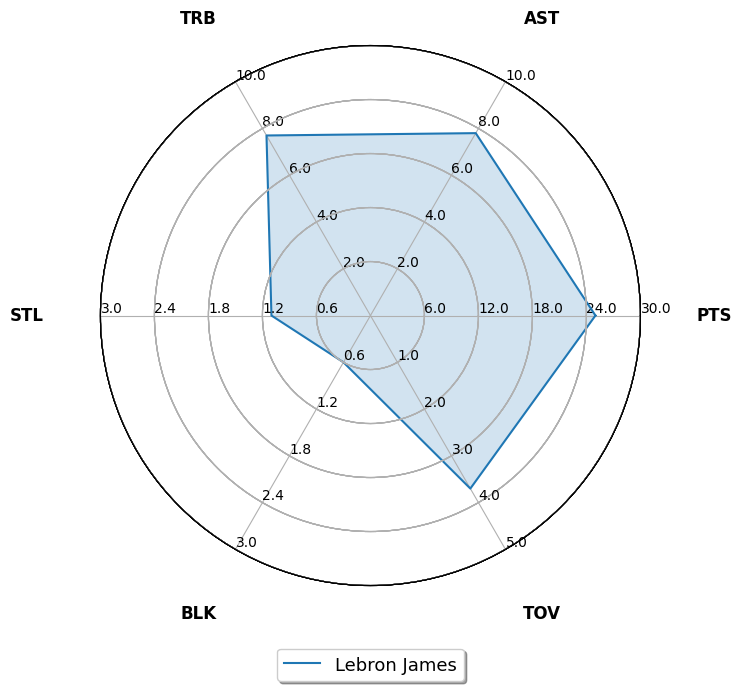

In [103]:
# plotting
fig1 = plt.figure(figsize=(6, 6))
radar = ComplexRadar(fig1, variables, ranges)

data = list(df_dict.values())
radar.plot(data, label='Lebron James')
radar.fill(data, alpha=0.2)

radar.ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10),
      fancybox=True, shadow=True, ncol=4, fontsize=13)
plt.show()

# Prueba 2 jugadores

In [105]:
df_1, df_2 = generate_data_for_comparison('Lebron James','Stephen Curry',2020)

In [107]:
df_2

index,PTS,AST,TRB,STL,BLK,TOV
Stephen Curry,20.8,6.6,5.2,1.0,0.4,3.2


In [116]:
df_2.index[0]

'Stephen Curry'

In [117]:
{key: value[df_1.index[0]] for key, value in df_1.to_dict().items()}

{'PTS': 25.3, 'AST': 10.2, 'TRB': 7.8, 'STL': 1.2, 'BLK': 0.5, 'TOV': 3.9}

In [120]:
df_1_dict = {key: value[df_1.index[0]] for key, value in df_1.to_dict().items()}
df_2_dict = {key: value[df_2.index[0]] for key, value in df_2.to_dict().items()}

In [121]:
df_1_dict

{'PTS': 25.3, 'AST': 10.2, 'TRB': 7.8, 'STL': 1.2, 'BLK': 0.5, 'TOV': 3.9}

In [129]:
df_2_dict

{'PTS': 20.8, 'AST': 6.6, 'TRB': 5.2, 'STL': 1.0, 'BLK': 0.4, 'TOV': 3.2}

In [126]:
for player,dictionary in zip(player_names,[df_1_dict,df_2_dict]):
    print(player)

Lebron James


In [132]:
def plot_comparison(df_1,df_2):

    df_1_dict = {key: value[df_1.index[0]] for key, value in df_1.to_dict().items()}
    df_2_dict = {key: value[df_2.index[0]] for key, value in df_2.to_dict().items()}

    # plotting

    player_names = [df_1.index[0],df_2.index[0]]
    variables = stats
    ranges = [(0, 30), (0, 11), (0, 10), (0, 3), (0, 3), (0, 5)]

    fig1 = plt.figure(figsize=(6, 6))
    radar = ComplexRadar(fig1, variables, ranges)
    
    for player,dictionary in zip(player_names,[df_1_dict,df_2_dict]):
        data = list(dictionary.values())
        radar.plot(data, label=player)
        radar.fill(data, alpha=0.2)

    radar.ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10),
        fancybox=True, shadow=True, ncol=4, fontsize=13)
    plt.show()

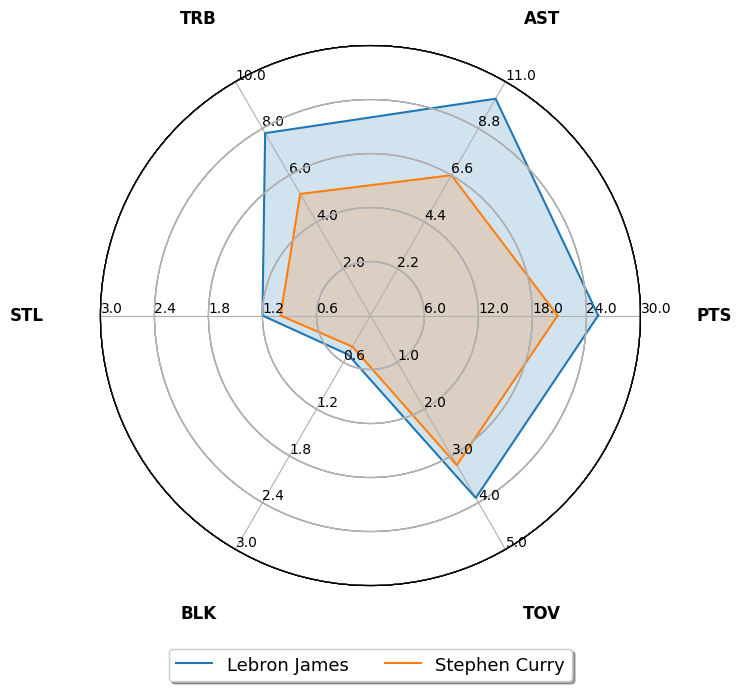

In [133]:
plot_comparison(df_1,df_2)